# Mental health model

In [53]:
wd = r'D:\natcap\invest-mental-health\data'

import os
os.chdir(wd)
os.getcwd()

import re
import csv
import pandas as pd
import numpy as np
import geopandas as gpd

import rasterio
import matplotlib.pyplot as plt


### Import system modules
# import arcpy
# from arcpy import env
# import os, glob, fnmatch, sys
# from arcpy.sa import *
## Check out ArcGIS Spatial Analyst extension license
# arcpy.gp.CheckOutExtension("Spatial")
# ### Set environment settings
# arcpy.env.workspace = wd
# arcpy.env.overwriteOutput = True
# arcpy.env.compression = 'LZW'    # Lossless compression preserves all raster cell values


# Input data

## Shapefiles

In [54]:
# Load the shapefile
shapefile_path = 'cb_2019_us_county_500k_06075_clip.shp'
gdf = gpd.read_file(shapefile_path)




## Land cover 

### Load raw LC layer

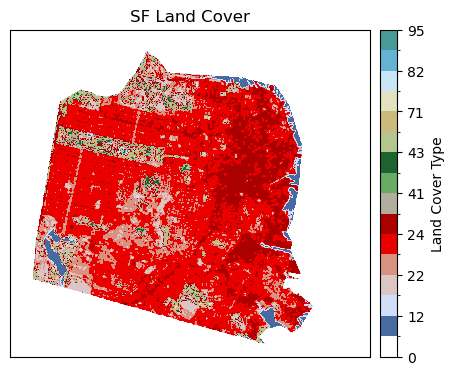

In [55]:

## load lulc map 
lc_img = "nlcd_2019_land_cover_SF.tif"

with rasterio.open(lc_img) as src:
    # Assuming an RGB image
    # Read the raster data as a numpy array
    land_cover = src.read(1)  # Read the first band; adjust if your data has multiple bands

    # Plotting parameters, considering the raster's metadata
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)


# Example color map (adjust the values and classes according to your data)
# NLCD class codes and corresponding colors (from the NLCD legend)
nlcd_class_values = {
    0: (0, 0, 0, 0),    # Transparent background
    11: "#476BA1",      # Open Water
    12: "#D1DEF8",      # Perennial Ice/Snow
    21: "#DEC5C5",      # Developed, Open Space
    22: "#D99282",      # Developed, Low Intensity
    23: "#EB0000",      # Developed, Medium Intensity
    24: "#AB0000",      # Developed, High Intensity
    31: "#B3AC9F",      # Barren Land
    41: "#68AB63",      # Deciduous Forest
    42: "#1C6330",      # Evergreen Forest
    43: "#B5C58F",      # Mixed Forest
    52: "#CCBA7C",      # Shrub/Scrub
    71: "#E2E2C1",      # Herbaceous
    81: "#C8E6F8",      # Hay/Pasture
    82: "#64B3D5",      # Cultivated Crops
    90: "#64ACD7",      # Woody Wetlands
    95: "#499996"       # Emergent Herbaceous Wetlands
}

import matplotlib.colors as mcolors

# Create a color map from the defined colors
nlcd_cmap = mcolors.ListedColormap([nlcd_class_values[key] for key in sorted(nlcd_class_values.keys())])
nlcd_norm = mcolors.BoundaryNorm(sorted(nlcd_class_values.keys()), nlcd_cmap.N)



# Create a plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 5))
plt.title('SF Land Cover', loc='center')
cax = ax.imshow(land_cover, cmap=nlcd_cmap, norm=nlcd_norm)

# Create a new axes on the right of the current axes for the colorbar
divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label('Land Cover Type')

# Remove the x and y ticks and labels
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks
ax.set_xlabel('')  # Remove x-axis label if previously set
ax.set_ylabel('')  # Remove y-axis label if previously set

plt.show()



### Reclassify lc

In [56]:
# Open the NLCD GeoTIFF file
with rasterio.open(lc_img) as src:
    # Read the data into a variable
    nlcd_data = src.read(1)  # Assuming the land cover data is in the first band

    # List of developed land cover codes
    developed_codes = [21, 22, 23, 24, 82]

    # Change all developed land cover codes to 0
    for code in developed_codes:
        nlcd_data[nlcd_data == code] = 0

    # Prepare output metadata from source
    out_meta = src.meta


## Only take forest as greenspace -------------------------------------------------------
# Open the NLCD GeoTIFF file
with rasterio.open(lc_img) as src:
    # Read the data into a variable
    lc_forest = src.read(1)  # Assuming the land cover data is in the first band

    # List of developed land cover codes
    codes_remove = [11, 21, 22, 23, 24, 31, 52, 71, 81, 82, 90, 95, 128]

    # Change all developed land cover codes to 0
    for code in codes_remove:
        lc_forest[lc_forest == code] = 0

    # Prepare output metadata from source
    out_meta = src.meta
    nlcd_crs = src.crs  # Get the CRS of the raster


# Path for the modified output file
output_path = lc_img.replace('.tif', '_forest.tif'); print(output_path)
# Write the modified data back to a new GeoTIFF file
with rasterio.open(output_path, 'w', **out_meta) as dest:
    dest.write(lc_forest, 1)  # Write modified data to the first band



nlcd_2019_land_cover_SF_forest.tif


### Plot

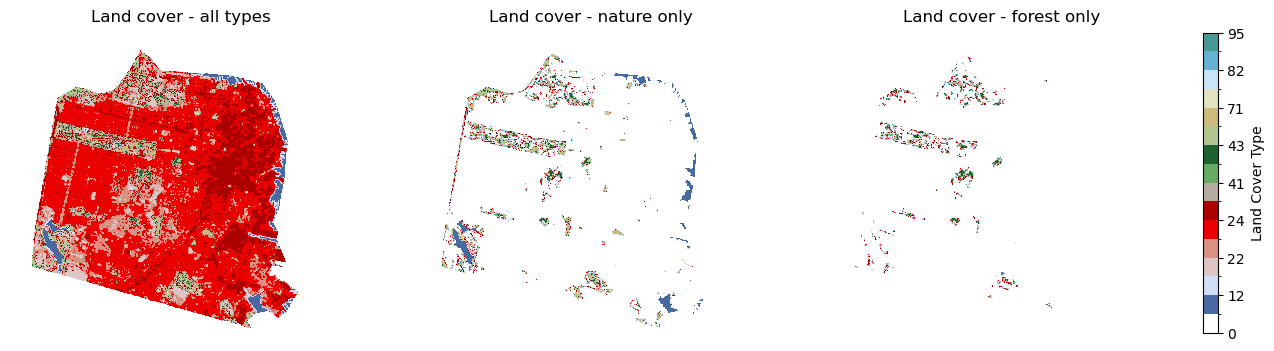

In [57]:

# fig, ax = plt.subplots(figsize=(5, 5))
# plt.title('SF Land Cover', loc='center')
# cax = ax.imshow(nlcd_data, cmap=nlcd_cmap, norm=nlcd_norm)

# # Create a new axes on the right of the current axes for the colorbar
# divider = make_axes_locatable(ax)
# cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
# cbar = fig.colorbar(cax, cax=cbar_ax)
# cbar.set_label('Land Cover Type')

# # Remove the x and y ticks and labels
# ax.set_xticks([])  # Remove x-axis ticks
# ax.set_yticks([])  # Remove y-axis ticks
# ax.set_xlabel('')  # Remove x-axis label if previously set
# ax.set_ylabel('')  # Remove y-axis label if previously set

# plt.show()



# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot first dataset
img1 = ax1.imshow(land_cover, cmap=nlcd_cmap, norm=nlcd_norm)
ax1.set_title('Land cover - all types')
ax1.axis('off')  # Remove axis ticks and labels

# Plot second dataset
img2 = ax2.imshow(nlcd_data, cmap=nlcd_cmap, norm=nlcd_norm)
ax2.set_title('Land cover - nature only')
ax2.axis('off')  # Remove axis ticks and labels

img3 = ax3.imshow(lc_forest, cmap=nlcd_cmap, norm=nlcd_norm)
ax3.set_title('Land cover - forest only')
ax3.axis('off')  # Remove axis ticks and labels

## Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.6])  # Adjust colorbar position and size: # [left, bottom, width, height]
cbar = fig.colorbar(img1, cax=cbar_ax)
cbar.set_label('Land Cover Type')

plt.show()

### Count by nature LC type

In [58]:
# Step 3: Count Each Land Cover Type

# Unique values and their counts
unique, counts = np.unique(lc_forest, return_counts=True)
land_cover_counts = dict(zip(unique, counts))

nlcd_labels = {
    11: "Open Water",
    12: "Perennial Ice/Snow",
    21: "Developed, Open Space",
    22: "Developed, Low Intensity",
    23: "Developed, Medium Intensity",
    24: "Developed, High Intensity",
    31: "Barren Land",
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest",
    52: "Shrub/Scrub",
    71: "Herbaceous",
    81: "Hay/Pasture",
    82: "Cultivated Crops",
    90: "Woody Wetlands",
    95: "Emergent Herbaceous Wetlands"
}

# Replace codes with labels
land_cover_counts_named = {nlcd_labels[code]: count for code, count in land_cover_counts.items() if code in nlcd_labels}


# Create DataFrame
land_cover_df = pd.DataFrame(list(land_cover_counts_named.items()), columns=['Land Cover Type', 'Count'])

# Display the DataFrame
print(land_cover_df)


    Land Cover Type  Count
0  Deciduous Forest      6
1  Evergreen Forest   3197
2      Mixed Forest    977


## Nature exposure - UNA

### UNA model result

In [59]:

# File paths for the two NLCD datasets

# file_path1 = './output/accessible_urban_nature_lucode_42.tif'
# file_path1 = 'usa_ppp_2020_UNadj_constrained_SF_proj_NoDataTo0.tif'
file_path1 = './output/urban_nature_demand.tif'
file_path2 = './output/urban_nature_supply_percapita.tif'



# Create a colormap from the NLCD color codes
nlcd_cmap = mcolors.ListedColormap([nlcd_class_values[key] for key in sorted(nlcd_class_values.keys())])
nlcd_norm = mcolors.BoundaryNorm(sorted(nlcd_class_values.keys()), nlcd_cmap.N)

# # Read the raster data
# with rasterio.open(file_path1) as src1, rasterio.open(file_path2) as src2:
#     data1 = src1.read(1)  # First dataset
#     # Mask no-data values
#     data1 = np.where(data1 == no_data_value, np.nan, data1)
#     data1_extent = [src_1.bounds.left, src_1.bounds.right, src_1.bounds.bottom, src_1.bounds.top]


#     nat_sup = src2.read(1)  # Second dataset
#     nat_sup = np.where(nat_sup == no_data_value, np.nan, nat_sup)

# # Define the no-data value if known (e.g., -9999 or 0)
no_data_value = -9999  # Update this value based on your data's specifics

# Open the population density raster
with rasterio.open(file_path1) as src_1:
    data1 = src_1.read(1)  # Read the first band
    # Mask no-data values
    
    # data1 = np.where(data1 == no_data_value, np.nan, data1)
    # Mask no-data values to NaN for transparency
    data1[data1 < 0] = np.nan ## 
    data1_bounds = src_1.bounds
    data1_extent = [data1_bounds.left, data1_bounds.right, data1_bounds.bottom, data1_bounds.top]

    # data1_extent = [src_1.bounds.left, src_1.bounds.right, src_1.bounds.bottom, src_1.bounds.top]

# Open the DEM raster
with rasterio.open(file_path2) as src2:
    nat_sup = src2.read(1)  # Read the first band
    # Mask no-data values
    nat_sup = np.where(nat_sup == no_data_value, np.nan, nat_sup)
    nat_extent = [src2.bounds.left, src2.bounds.right, src2.bounds.bottom, src2.bounds.top]
    raster_crs = src2.crs  # Get the CRS of the raster
    dem_transform = src2.transform
    raster_profile = src2.profile  # We'll use this for writing output


# ## use histgram to identify the NoData values, and to fix color-show issue on the map
# from rasterio.plot import show_hist
# show_hist(data1, bins=50, lw=0.0, stacked=False, alpha=0.3,
#     histtype='stepfilled', title="Histogram")



## Reproject the Shapefile
# Check if the CRS matches, and reproject if necessary
if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)

gdf2 = gdf
if gdf2.crs != nlcd_crs:
    gdf2 = gdf2.to_crs(nlcd_crs)



### Reproject NLCD raster

In [60]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

target_crs = raster_crs

# Path to the NLCD raster
nlcd_path = "nlcd_2019_land_cover_SF_forest.tif"
     
# Open the NLCD raster and reproject it if necessary
with rasterio.open(nlcd_path) as nlcd:
    nlcd_data = nlcd.read(1)  # Assume NLCD data is in the first band
    nlcd_transform = nlcd.transform
    nlcd_crs = nlcd.crs

    if nlcd_crs != target_crs:
        print("Reprojecting NLCD raster...")
        # Calculate the new transform and dimensions for the NLCD raster
        transform, width, height = calculate_default_transform(
            nlcd.crs, target_crs, nlcd.width, nlcd.height, *nlcd.bounds)
        # Create a new array to hold the reprojected NLCD data
        reprojected_nlcd = np.empty((height, width), dtype=nlcd_data.dtype)
        # Reproject the NLCD data
        reproject(
            source=nlcd_data,
            destination=reprojected_nlcd,
            src_transform=nlcd_transform,
            src_crs=nlcd_crs,
            dst_transform=dem_transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest)
    else:
        print("No reprojection needed.")
        reprojected_nlcd = nlcd_data
        transform = nlcd_transform

nodata = -128
reprojected_nlcd = np.ma.masked_values(reprojected_nlcd, nodata)
nodata = 0
reprojected_nlcd = np.ma.masked_values(reprojected_nlcd, nodata)

No reprojection needed.


### Plot

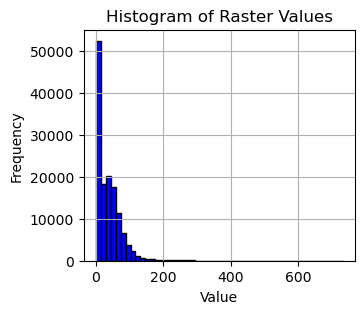

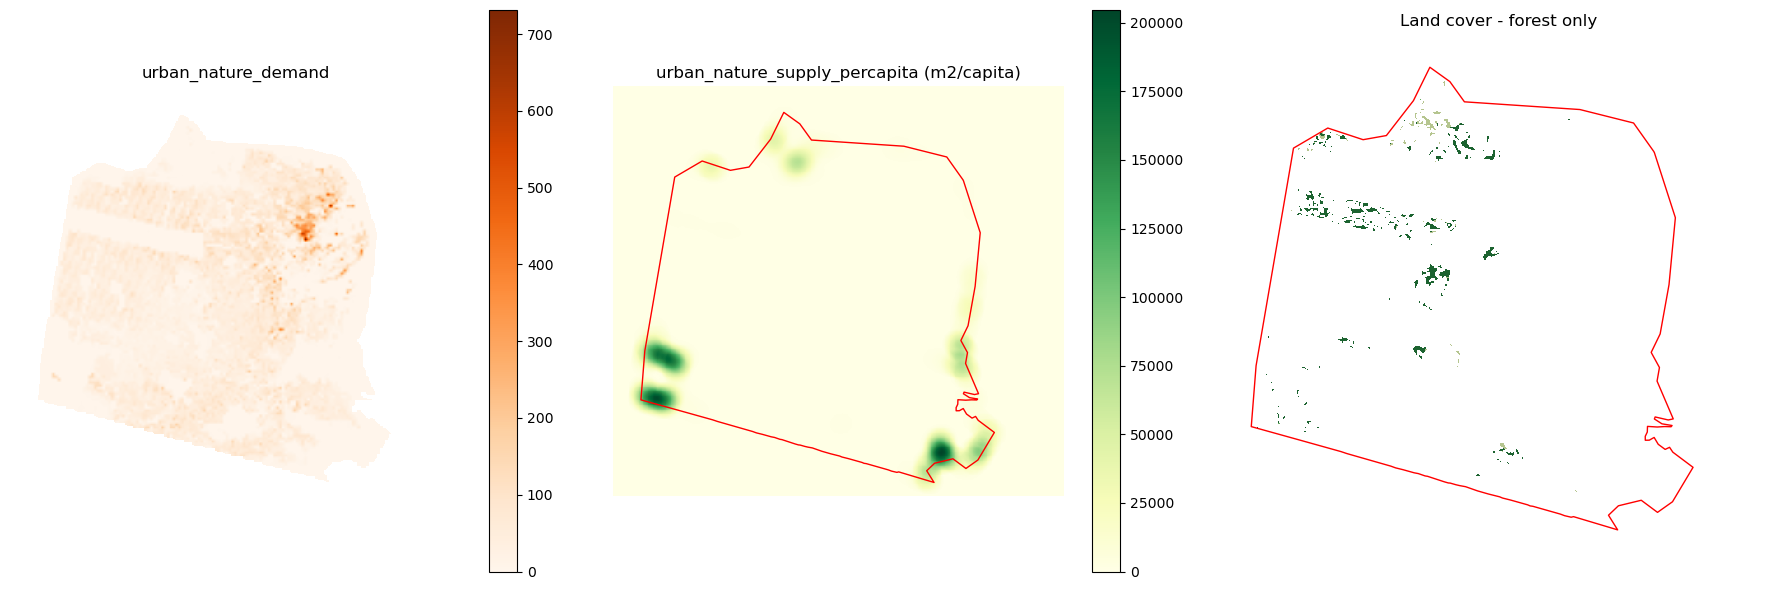

In [61]:

# Assuming the no-data value is known
no_data_value = src.nodata  # Or set it manually if not defined
# Mask no-data values
data1 = np.ma.masked_equal(data1, no_data_value)
plt.figure(figsize=(3.5, 3))
plt.hist(data1.compressed(), bins=50, color='blue', edgecolor='black')  # Compressed removes the masked values from the array
plt.title('Histogram of Raster Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

## Plot urban_nature_demand
cax1 = ax1.imshow(data1, cmap='Oranges', extent=data1_extent, interpolation='nearest')
ax1.set_title('urban_nature_demand')
ax1.axis('off')  # Remove axis ticks and labels
fig.colorbar(cax1, ax=ax1, orientation='vertical')
# Overlay the shapefile
ax1.set_xlim(data1_extent[0], data1_extent[1])
ax1.set_ylim(data1_extent[2], data1_extent[3])


## Plot urban_nature_supply_percapita
cax2 = ax2.imshow(nat_sup, cmap='YlGn', extent=nat_extent, interpolation='nearest')
ax2.set_title('urban_nature_supply_percapita (m2/capita)')
ax2.axis('off')  # Remove axis ticks and labels
fig.colorbar(cax2, ax=ax2, orientation='vertical')
gdf.plot(ax=ax2, edgecolor='red', facecolor='none')  # Adjust colors

## plot NLCD 
# unique_values = np.unique(reprojected_nlcd)
# # Convert a masked array to a regular array with NaNs where data is masked
# unique_values = np.where(unique_values.mask, np.nan, unique_values.data)
# Extract unique values and remove NaN values
# unique_values = np.unique(reprojected_nlcd[~np.isnan(reprojected_nlcd)])
## Remove np.nan values
# unique_values = unique_values[~np.isnan(unique_values)]
# import matplotlib.colors as mcolors
# # Create a colormap with a color for each unique value
# # colors = plt.cm.get_cmap('Dark2', len(unique_values))  # 'tab20' has 20 unique colors, adjust as needed
# # cmap = mcolors.ListedColormap(colors(np.linspace(0, 1, len(unique_values))))
# norm = mcolors.BoundaryNorm(unique_values, cmap.N)
# print((unique_values))
# print(len(unique_values))

# img3 = ax3.imshow(reprojected_nlcd, cmap=nlcd_cmap, norm=nlcd_norm)
cax3 = ax3.imshow(reprojected_nlcd, 
                  # cmap='winter', #, 'Dark2',
                  # cmap=cmap, # norm=norm,
                  cmap=nlcd_cmap, norm=nlcd_norm, 
                  extent=extent)
ax3.set_title('Land cover - forest only')
ax3.axis('off')  # Remove axis ticks and labels
# gdf2.plot(ax=ax3, edgecolor='red', facecolor='none')  # Adjust colors
gdf.plot(ax=ax3, edgecolor='red', facecolor='none')  # Adjust colors
# fig.colorbar(cax3, ax=ax3, orientation='vertical')

# # Add a colorbar with labels for each unique value
# cbar = fig.colorbar(cax3, ticks=np.arange(min(unique_values), max(unique_values)+1))
# cbar.set_ticklabels(unique_values)
# cbar.set_label('Unique Values')

# Display the plots
plt.tight_layout()
plt.show()



### To determine what counts as "nature exposure"?

75.86


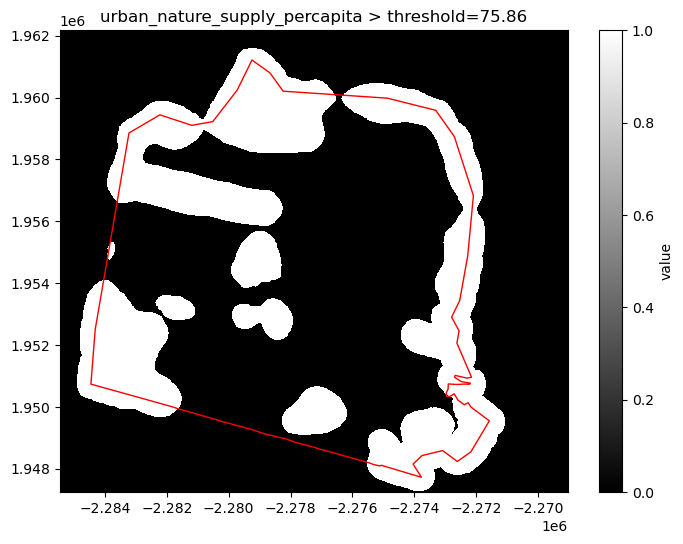

In [62]:
# Compute the median value of the DEM
threshold = np.nanmedian(nat_sup[nat_sup != src.nodata])  # Exclude no-data values in the calculation
threshold = np.percentile(nat_sup[nat_sup != src.nodata], 75)

threshold = round(threshold, 2)
print(threshold)


# Reclassify the DEM
nat_sup_nat1 = np.where(nat_sup > threshold, 1, 0)
# Mask out the no-data areas to keep them unchanged
nat_sup_nat1[nat_sup == src.nodata] = src.nodata

# Path for the reclassified DEM
nat_sup_nat1_path = 'nat_sup_nat1.tif'

fig, ax = plt.subplots(figsize=(10, 6))
# Plot the raster
raster_show = plt.imshow(nat_sup_nat1, 
                         extent=nat_extent, 
                         cmap='gray', interpolation='none')  # adjust cmap as needed
# Overlay the vector (shapefile)
gdf.plot(ax=ax, facecolor='none', edgecolor='red')  # adjust colors as needed
# Optional: add a colorbar
cbar = fig.colorbar(raster_show, ax=ax, fraction=0.036, pad=0.04, label='value')
ax.set_title('urban_nature_supply_percapita > threshold=' + str(threshold))
plt.show()



## Effect size

In [63]:

## load lulc table
lc_xls = "lulc-attributes_NLCD_SF3.xlsx"
lc_tab = pd.read_excel(lc_xls, engine='openpyxl')
lc_tab


,lulc_code,NLCD_Land,nature_yes,search_radius_m,nature_code,effect_size_anxiety,effect_size_depression
0,11,Open Water,1,1000,1201,-0.413858,-0.374721
1,21,"Developed, Open Space",1,1000,1005,-0.474147,-0.173643
2,22,"Developed, Low Intensity",0,1000,9999,0.000000,0.000000
3,23,"Developed, Medium Intensity",0,1000,9999,0.000000,0.000000
4,24,"Developed, High Intensity",0,1000,9999,0.000000,0.000000
5,31,Barren Land,1,1000,1000,0.000000,0.000000
6,41,Deciduous Forest,1,1000,1001,-1.582706,-0.903320
7,42,Evergreen Forest,1,1000,1001,-1.582706,-0.903320
8,43,Mixed Forest,1,1000,1001,-1.582706,-0.903320
9,52,Shrub/Scrub,1,1000,1002,NaN,NaN


-0.413857558776701


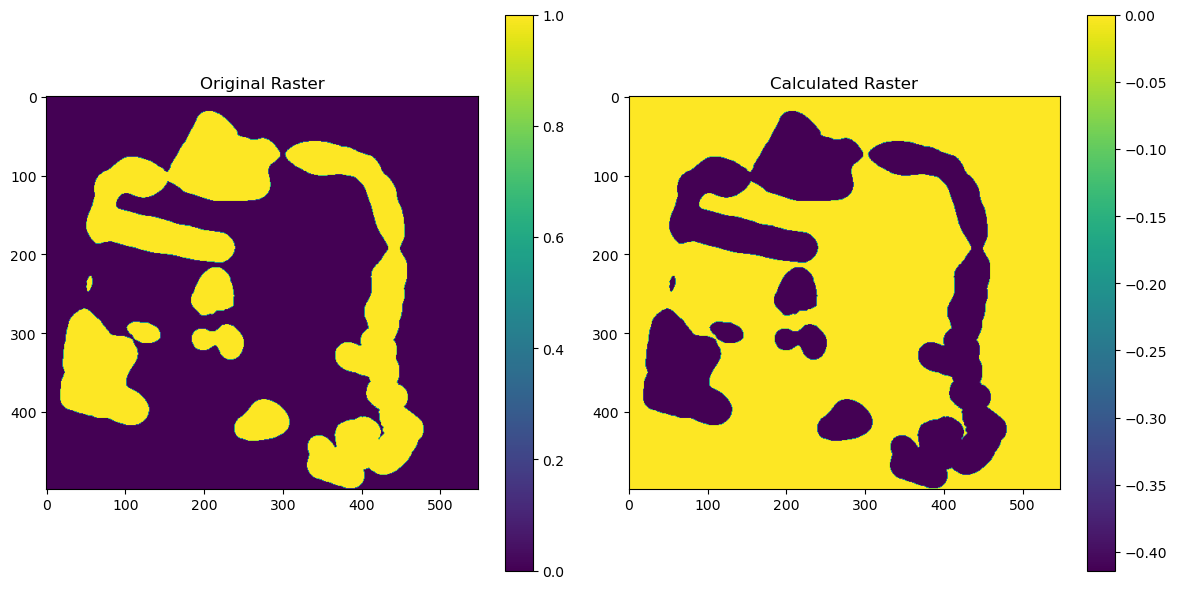

In [64]:
# Assume you need a specific value from a column named 'Parameter'
# Let's also assume you are interested in the first row of this column
value_from_excel = lc_tab['effect_size_anxiety'][0]

print(value_from_excel)

# Calculate new raster values
# E.g., multiply each pixel by the value from Excel
new_raster_data = nat_sup_nat1 * value_from_excel

# Handle no-data values appropriately
new_raster_data[nat_sup_nat1 == src.nodata] = src.nodata


## Save the Calculated Raster
output_raster_path = 'output_raster.tif'

# Write the new raster data
with rasterio.open(output_raster_path, 'w', **raster_profile) as dst:
    dst.write(new_raster_data, 1)



## Visualizing the Result 

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(nat_sup_nat1, cmap='viridis')
plt.title('Original Raster')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(new_raster_data, cmap='viridis')
plt.title('Calculated Raster')
plt.colorbar()

plt.tight_layout()
plt.show()
